In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from copy import deepcopy
from statistics import mean

# Prepare Outcome Measure + DF

In [87]:
outcome_2020_1 = pd.read_excel("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Ranking Data\\Startups1920_1_evaluations+rankings_allinvestors.xlsx", skiprows=[1])
outcome_2020_2 = pd.read_excel("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Ranking Data\\Startups1920_2_evaluations+rankings_allinvestors.xlsx", skiprows=[1])
outcome_2019 = pd.read_excel("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Ranking Data\\Startups1819_evaluations+rankings_allinvestors.xlsx", skiprows=[1])
outcome_deia = pd.read_excel("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Ranking Data\\DEiAIII1920_SM1_evaluations+rankings_allinvestors.xlsx", skiprows=[1])

In [88]:
outcome_2019.head()

,wave,pitchid,pitch,student,investorid,investor,coach1,coach2,coach3,coach4,...,originality,desirability,feasibility,risk1,risk2,risk3,risk4,confbusiness,related,ranking
0,1,1,Little Sister,Hero de Smeth,1,Remco Verhoef,4,4,4,4,...,3,4,4,4,3,2,4,5,0,2
1,1,1,Little Sister,Hero de Smeth,2,Tim Stribos,3,4,3,4,...,3,3,3,4,4,2,3,5,3,4
2,1,1,Little Sister,Hero de Smeth,3,Sjoerd Coolen,4,4,4,4,...,3,4,4,4,5,3,1,6,9,1
3,1,2,FLIPR,Neil Timmermans,1,Remco Verhoef,3,3,3,3,...,2,4,3,1,2,1,3,5,0,4
4,1,2,FLIPR,Neil Timmermans,2,Tim Stribos,3,3,3,3,...,2,4,5,2,2,2,4,7,10,1


In [89]:
frames = [outcome_2019, outcome_2020_1, outcome_2020_2, outcome_deia]

In [90]:
outcomes = pd.concat(frames)
outcomes = outcomes[['pitch', 'investorid', 'ranking', 'probinv', 'probsuc', 'quality', 'confbusiness', 'risk4']]
outcomes

,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4
0,Little Sister,1,2,50,60,65,5.0,4.0
1,Little Sister,2,4,15,50,45,5.0,3.0
2,Little Sister,3,1,60,60,70,6.0,1.0
3,FLIPR,1,4,40,50,60,5.0,3.0
4,FLIPR,2,1,80,80,80,7.0,4.0
...,...,...,...,...,...,...,...,...
10,Whitebox,2,3,60,60,70,6.0,3.0
11,Whitebox,3,2,80,90,90,6.0,2.0
12,Soccer Academy,1,4,30,50,60,6.0,4.0
13,Soccer Academy,2,2,50,80,80,6.0,2.0


# Calculate Outcome Measure

## Methods

Below the measures are described/mentioned as they are defined in the Jiang et al. paper

#### What defines Joy/Happiness:
* Cheeck Raiser
* Lip corner Puller

#### Peak Displayed Joy:
Displayed joy score ranging from 0 to 10. Highest score for joy is peak displayed joy value

#### Peak Displayed Joy Duration:
Duration of the peak value of joy


#### Control Variables:

Pitch Level
* Joy trajectory (increase vs decrease over time)
* Last second displayed joy
* First second displayed joy
* Average displayed joy
* Average displayed negative emotions
* Video length (not applicable)
* Video length with facials (not applicable)

Project Level
* Funding goal (controls for risk averse people backing the project)
* Project duration (fixed in this setting)
* Project location (fixed in this setting)
* Number of reward levels (kickstarter)
* Project category

Entrepreneur Level (experience)
* Number of prior projects funded
* Number of prior projects backed by entrepreneurs
* Number of updates

In [91]:
def duration_calculation(data):
    
    """ This function checks how long the peak duration of joy lasts. As the emotion values are never the same at any one
    point a 2% margin is taken to make sure we correctly measure the duration of the peak."""
    
    index_of_max = data['Happy'].argmax()
    
    max_value = data['Happy'].max()
    margin = 0.025 * max_value
    lower_bound = max_value - margin
    upper_bound = max_value + margin
    
    # Check if rows before fall within margin
    while index_of_max >= 1:
        index_of_max = index_of_max - 1
        
        if lower_bound <= data.at[index_of_max, 'Happy'] <= upper_bound:
            pass
        else:
            break
    
    min_index = index_of_max
    
    # Reset counter
    index_counter = data['Happy'].argmax()
    
    # Finally check later rows
    while index_counter < len(data)-1:
        index_counter = index_counter + 1
        
        if lower_bound <= data.at[index_counter, 'Happy'] <= upper_bound:
            pass
        else:
            break
    
    max_index = index_counter
    
    max_time = data.loc[max_index, 'Video Time']
    min_time = data.loc[min_index, 'Video Time']
    
    duration = max_time - min_time
    duration_seconds = duration.total_seconds()
    
    return duration_seconds
    
    
    

In [92]:
regression_data = pd.DataFrame(columns = ['Participant', 'Peak Joy', 'Peak Joy Duration'])

# Loop over every FaceReader data file and extract relevant information
for filename in os.listdir('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data'):
    
    data_par = pd.read_csv('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data\{}'.format(filename))
    
    data_par['Video Time'] = pd.to_datetime(data_par['Video Time'])

    
    # Replace FaceReader values with NaNs
    data_par = data_par.replace('FIT_FAILED', np.nan)
    data_par = data_par.replace('FIND_FAILED', np.nan)
    
    # Make emotion columns numeric
    data_par['Happy'] = pd.to_numeric(data_par['Happy'])
    data_par['Neutral'] = pd.to_numeric(data_par['Neutral'])
    data_par['Sad'] = pd.to_numeric(data_par['Sad'])
    data_par['Angry'] = pd.to_numeric(data_par['Angry'])
    data_par['Surprised'] = pd.to_numeric(data_par['Surprised'])
    data_par['Scared'] = pd.to_numeric(data_par['Scared'])
    data_par['Disgusted'] = pd.to_numeric(data_par['Disgusted'])
    
    
    peak_joy  = data_par['Happy'].max()  # Get max value of happy as peak joy
    peak_joy_duration = duration_calculation(data_par)   
    
    regression_data.loc[len(regression_data)] = [filename, peak_joy, peak_joy_duration]

C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = awai

In [93]:
regression_data.Participant

0             Short_4Peech Student.csv
1        Short_Ar-T-Ficial Student.csv
2         Short_Bubble Pop Student.csv
3           Short_Chattern Student.csv
4      Short_Choos3 Wisely Student.csv
5             Short_FindIT Student.csv
6           Short_FitPoint Student.csv
7              Short_FLIPR Student.csv
8           Short_HoodFood Student.csv
9             Short_HOTIDY Student.csv
10     Short_Little Sister Student.csv
11            Short_LockUp Student.csv
12              Short_PREA Student.csv
13         Short_Recipe-Me Student.csv
14        Short_RecognEyes Student.csv
15    Short_Salix Student_Analysis.csv
16             Short_SmArt Student.csv
17    Short_Soccer Academy Student.csv
18             Short_SOLON Student.csv
19       Short_StudentFood Student.csv
20            Short_tAIste Student.csv
21            Short_wAIste Student.csv
22          Short_Whitebox Student.csv
23    Short_Young Boosters Student.csv
24          Short_Ziggurat Student.csv
Name: Participant, dtype:

In [94]:
regression_data.to_csv("output_peak_duration.csv", index=False)

In [95]:
regression_data = pd.read_csv("output_peak_duration.csv")

In [96]:
regression_data['pitch'] = None

In [97]:
regression_data.tail(10)

,Participant,Peak Joy,Peak Joy Duration,pitch
15,Short_Salix Student_Analysis.csv,0.059034,0.100,None
16,Short_SmArt Student.csv,0.600791,0.200,None
17,Short_Soccer Academy Student.csv,0.121066,0.080,None
18,Short_SOLON Student.csv,0.492315,0.366,None
19,Short_StudentFood Student.csv,0.268151,0.200,None
20,Short_tAIste Student.csv,0.796148,0.500,None
21,Short_wAIste Student.csv,0.585253,0.266,None
22,Short_Whitebox Student.csv,0.239679,0.200,None
23,Short_Young Boosters Student.csv,0.448028,0.200,None
24,Short_Ziggurat Student.csv,0.777705,0.240,None


In [98]:
for index, row in regression_data.iterrows():
    for name in outcomes['pitch']:
        
        if name in row['Participant']:
            regression_data.at[index, 'pitch'] = name

In [99]:
regression_data = regression_data[['Peak Joy', 'Peak Joy Duration', 'pitch']]
regression_data

,Peak Joy,Peak Joy Duration,pitch
0,0.889778,0.500,Peech
1,0.243507,0.200,Ar-T-Ficial
2,0.514820,0.200,Bubble Pop
3,0.712856,0.266,Chattern
4,0.021580,0.067,Choos3 Wisely
5,0.794228,0.233,FindIT
6,0.678607,0.300,FitPoint
7,0.375191,0.040,FLIPR
8,0.557620,0.166,HoodFood
9,0.331371,0.200,HOTIDY


In [100]:
regression_data = pd.merge(regression_data, outcomes, on='pitch', how='inner')
regression_data.to_csv("regression_data_v1.csv", index = False)

## What does peak joy look like?

In [101]:
regression_data.iloc[:10]

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4
0,0.889778,0.500,Peech,1,2,70,70,80,7.0,3.0
1,0.889778,0.500,Peech,2,4,20,10,30,7.0,NaN
2,0.889778,0.500,Peech,3,4,5,5,5,6.0,5.0
3,0.243507,0.200,Ar-T-Ficial,1,4,30,30,40,6.0,4.0
4,0.243507,0.200,Ar-T-Ficial,2,3,60,50,40,7.0,5.0
5,0.243507,0.200,Ar-T-Ficial,3,3,10,20,20,6.0,2.0
6,0.514820,0.200,Bubble Pop,1,7,15,25,30,5.0,4.0
7,0.514820,0.200,Bubble Pop,2,7,0,5,5,5.0,4.0
8,0.514820,0.200,Bubble Pop,3,6,0,10,40,6.0,2.0
9,0.712856,0.266,Chattern,1,1,50,50,60,6.0,4.0


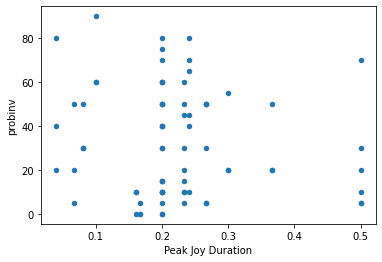

In [102]:
regression_data.plot.scatter(x='Peak Joy Duration', y='probinv')

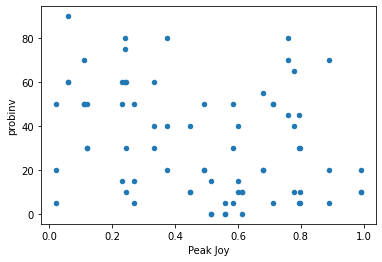

In [103]:
regression_data.plot.scatter(x='Peak Joy', y='probinv')

## Get Control Variables

### Control Variables 1st Iteration

Student Survey 1:

* In general, starting a business is ... (attitude towards venturing) -> ATV1_1, ATV1_2 ATV1_3
* What is your level of experience in ... (entrepreneurial experience) -> EE1-3_1,EE1-3_2,EE1-3_3
* Which members of your family are involved or have been involved in self-employment/small business? -> EE6
* Age -> D1
* Gender -> D2
* Number of years of full-time university education -> D4

Student Survey 2:

In [104]:
regression_data = pd.read_csv("regression_data_v1.csv")
regression_data.head()

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4
0,0.889778,0.5,Peech,1,2,70,70,80,7.0,3.0
1,0.889778,0.5,Peech,2,4,20,10,30,7.0,NaN
2,0.889778,0.5,Peech,3,4,5,5,5,6.0,5.0
3,0.243506,0.2,Ar-T-Ficial,1,4,30,30,40,6.0,4.0
4,0.243506,0.2,Ar-T-Ficial,2,3,60,50,40,7.0,5.0


### Startups 2018-2019

In [105]:
survey1= pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 1 - Startups1819 - CSV Numeric Values.csv")
survey2 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 2 - Startups1819 - CSV Numeric Values.csv")

In [106]:
last_name_dict = {"Little Sister": "h.p.smeth@student.tue.nl", "FLIPR": "n.n.timmermans@student.tue.nl", 
                  "Bubble Pop": "m.tresoor@student.tue.nl", "RecognEyes": "w.w.l.nuijten@student.tue.nl", 
                 "HOTIDY": "d.dinkla@student.tue.nl", "FitPoint": "e.m.locusteanu@student.tue.nl", 
                  "SOLON": "olivierspinnler@hotmail.com"}

In [107]:
survey1['pitch'] = None

for index, row in regression_data.iterrows():
    
    try:
        email_address = last_name_dict[row['pitch']]
        
        survey1_index = survey1.index[survey1['UEA1'] == email_address].to_list()

        survey1.at[survey1_index[0], 'pitch'] = row['pitch']
    except:
        continue

survey1 = survey1[survey1['pitch'].notna()].reset_index()

In [108]:
survey1 = survey1[['pitch', "ATV1_1", "ATV1_2", "ATV1_3", "EE1-3_1", "EE1-3_2", "EE1-3_3", "D1", "D2", "D4"]]

In [109]:
survey_2018 = survey1

### Startups 2019-2020

In [110]:
survey1 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 1 - Startups1920 - CSV Numeric Values_exclTomvMeer.csv")
survey2 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 2 - Startups1920 - CSV Numeric Values.csv")

In [111]:
last_name_dict = {"tAIste": "l.l.snijder@student.tue.nl", 'Choos3 Wisely': 'm.petkovic.1@student.tue.nl',
                 'SmArt': 'm.m.g.heine@tilburguniversity.edu', 'StudentFood': 'a.majhi@student.tue.nl',
                 'wAIste': "i.l.v.d.heuvel@student.tue.nl ", "Chattern": "r.s.v.eggelen@student.tue.nl",
                 'FindIT': 'j.kareem@tilburguniversity.edu ', 'Ar-T-Ficial': 'm.v.loon@student.tue.nl',
                 'Recipe-Me': 'o.h.morra@student.tue.nl', 'Salix': "T.j.kerkhof@uvt.nl",
                 'Peech': 'I.rutgers@tue.student.nl', 'HoodFood': 's.papandroudis@uvt.nl,',
                 'LockUp': 'j.h.yang@student.tue.nl', "Little Sister": "h.p.smeth@student.tue.nl", "FLIPR": "n.n.timmermans@student.tue.nl", 
                  "Bubble Pop": "m.tresoor@student.tue.nl", "RecognEyes": "w.w.l.nuijten@student.tue.nl", 
                 "HOTIDY": "d.dinkla@student.tue.nl", "FitPoint": "e.m.locusteanu@student.tue.nl", 
                  "SOLON": "olivierspinnler@hotmail.com"}

In [112]:
survey1['pitch'] = None

for index, row in regression_data.iterrows():
    
    try:
        email_address = last_name_dict[row['pitch']]
        
        survey1_index = survey1.index[survey1['UEA1'] == email_address].to_list()

        survey1.at[survey1_index[0], 'pitch'] = row['pitch']
    except:
        continue

survey1 = survey1[survey1['pitch'].notna()].reset_index()

In [113]:
survey_2019 = survey1[['pitch', "ATV1_1", "ATV1_2", "ATV1_3", "EE1-3_1", "EE1-3_2", "EE1-3_3", "D1", "D2", "D4"]]

In [114]:
surveys = survey_2018.append(survey_2019).reset_index(drop=True)

### DEiA 3

In [115]:
survey1 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 1 - DEiAIII1920_SM1 - CSV Numeric Values.csv")
survey2 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Student Survey 2 - DEiAIII1920_SM1 - CSV Numeric Values.csv")

In [116]:
last_name_dict = {"Ziggurat": "z.mapar@tilburguniversity.edu ", "PREA": "l.c.p.v.d.sanden@student.tue.nl",
                 "Young Boosters": "n.d.sieraad@tilburguniversity.edu", "Whitebox": "j.wilhelm@tilburguniversity.edu",
                 "Soccer Academy": "y.elyandouzi@tilburguniversity.edu"}

In [117]:
survey1['pitch'] = None

for index, row in regression_data.iterrows():
    
    try:
        email_address = last_name_dict[row['pitch']]
        
        survey1_index = survey1.index[survey1['UEA1'] == email_address].to_list()

        survey1.at[survey1_index[0], 'pitch'] = row['pitch']
    except:
        continue

survey1 = survey1[survey1['pitch'].notna()].reset_index()

In [118]:
survey_2020 = survey1[['pitch', "ATV1_1", "ATV1_2", "ATV1_3", "EE1-3_1", "EE1-3_2", "EE1-3_3", "D1", "D2", "D4"]]

In [119]:
surveys = surveys.append(survey_2020).reset_index(drop=True)

In [120]:
surveys

,pitch,ATV1_1,ATV1_2,ATV1_3,EE1-3_1,EE1-3_2,EE1-3_3,D1,D2,D4
0,SOLON,2,2,2,14,14,14,22,1,4.5
1,FLIPR,2,2,2,15,15,15,22,1,4
2,Bubble Pop,2,2,2,13,13,14,21,1,2
3,FitPoint,2,2,2,15,15,13,21,2,3
4,RecognEyes,2,2,2,13,13,13,19,1,2
5,Little Sister,2,2,2,14,14,14,23,1,2
6,HOTIDY,2,2,2,14,13,13,21,1,2
7,Ar-T-Ficial,2,2,1,13,13,13,20,1,2
8,Salix,2,2,2,13,13,13,21,1,3
9,Peech,2,2,2,13,13,13,19,1,2


In [121]:
regression_with_control = pd.merge(regression_data, surveys, on='pitch', how='left')

In [122]:
regression_with_control

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,ATV1_1,ATV1_2,ATV1_3,EE1-3_1,EE1-3_2,EE1-3_3,D1,D2,D4
0,0.889778,0.50,Peech,1,2,70,70,80,7.0,3.0,2,2,2,13,13,13,19,1,2
1,0.889778,0.50,Peech,2,4,20,10,30,7.0,NaN,2,2,2,13,13,13,19,1,2
2,0.889778,0.50,Peech,3,4,5,5,5,6.0,5.0,2,2,2,13,13,13,19,1,2
3,0.243506,0.20,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,2,2,1,13,13,13,20,1,2
4,0.243506,0.20,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,2,2,1,13,13,13,20,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448028,0.20,Young Boosters,2,5,10,10,30,5.0,4.0,2,2,2,14,13,13,23,1,5
71,0.448028,0.20,Young Boosters,3,5,10,10,10,7.0,2.0,2,2,2,14,13,13,23,1,5
72,0.777705,0.24,Ziggurat,1,2,65,70,60,5.0,3.0,2,2,2,15,13,15,31,2,8.5
73,0.777705,0.24,Ziggurat,2,4,10,30,50,5.0,4.0,2,2,2,15,13,15,31,2,8.5


In [123]:
regression_with_control.to_csv('regression_with_control_v1.csv', index=False)

## Pitch Emotion Level Control Data

### Average Joy, First Second Joy, Last Second Joy

In [124]:
def first_second_joy(data):
    
    first_time = data.loc[0, 'Video Time']
    first_second_time = first_time + timedelta(seconds=1)
    
    first_second = data.loc[data['Video Time'] <= first_second_time]
    
    first_second_joy = first_second['Happy'].mean()
    
    return first_second_joy

In [125]:
def last_second_joy(data):
    
    last_time = data.loc[len(data)-1, 'Video Time']
    last_second_time = last_time - timedelta(seconds=1)
    
    last_second = data.loc[data['Video Time'] >= last_second_time]
    
    last_second_joy = last_second['Happy'].mean()
    
    return last_second_joy

In [126]:
def average_negative_emotions(data):
    
    
    sad_avg = data['Sad'].mean()
    angry_avg = data['Angry'].mean()
    scared_avg = data['Scared'].mean()
    disgusted_avg = data['Disgusted'].mean()
    
    mean_negative = mean([sad_avg, angry_avg, scared_avg, disgusted_avg])

    return mean_negative
    

In [127]:
regression_controls_pitch = pd.DataFrame(columns = ['Participant', 'Average_Joy', 'First_Second_Joy', 'Last_Second_Joy',
                                                   'Joy Trajectory', 'Average_Negative_Emotions'])

# Loop over every FaceReader data file and extract relevant information
for filename in os.listdir('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data'):
    
    joy_trajectory = np.nan
    
    data_par = pd.read_csv('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data\{}'.format(filename))
    
    data_par['Video Time'] = pd.to_datetime(data_par['Video Time'])

    
    # Replace FaceReader values with NaNs
    data_par = data_par.replace('FIT_FAILED', np.nan)
    data_par = data_par.replace('FIND_FAILED', np.nan)
    
    # Make emotion columns numeric
    data_par['Happy'] = pd.to_numeric(data_par['Happy'])
    data_par['Neutral'] = pd.to_numeric(data_par['Neutral'])
    data_par['Sad'] = pd.to_numeric(data_par['Sad'])
    data_par['Angry'] = pd.to_numeric(data_par['Angry'])
    data_par['Surprised'] = pd.to_numeric(data_par['Surprised'])
    data_par['Scared'] = pd.to_numeric(data_par['Scared'])
    data_par['Disgusted'] = pd.to_numeric(data_par['Disgusted'])
    
    
    average_joy  = data_par['Happy'].mean()  # Get mean value of joy
    
    first_s_joy = first_second_joy(data_par)
    
    last_s_joy = last_second_joy(data_par)
    
    mean_negative = average_negative_emotions(data_par)
    
    
    regression_controls_pitch.loc[len(regression_controls_pitch)] = [filename, average_joy, first_s_joy, last_s_joy, 
                                                                     joy_trajectory, mean_negative]

C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = awai

In [128]:
regression_controls_pitch.tail(10)

,Participant,Average_Joy,First_Second_Joy,Last_Second_Joy,Joy Trajectory,Average_Negative_Emotions
15,Short_Salix Student_Analysis.csv,0.013009,0.012775,0.006044,NaN,0.038414
16,Short_SmArt Student.csv,0.019110,0.154681,0.513803,NaN,0.073474
17,Short_Soccer Academy Student.csv,0.000762,0.000180,0.000825,NaN,0.066415
18,Short_SOLON Student.csv,0.009690,0.132485,0.000041,NaN,0.075667
19,Short_StudentFood Student.csv,0.017152,0.007738,0.015135,NaN,0.097340
20,Short_tAIste Student.csv,0.032931,0.054388,0.007616,NaN,0.032419
21,Short_wAIste Student.csv,0.116382,0.294756,0.270698,NaN,0.050635
22,Short_Whitebox Student.csv,0.003735,0.017960,0.000198,NaN,0.070368
23,Short_Young Boosters Student.csv,0.024736,0.254733,0.028479,NaN,0.106199
24,Short_Ziggurat Student.csv,0.025271,0.444054,0.207859,NaN,0.049878


In [129]:
regression_data = pd.read_csv("regression_with_control_v1.csv")
regression_data.pitch.unique()

array(['Peech', 'Ar-T-Ficial', 'Bubble Pop', 'Chattern', 'Choos3 Wisely',
       'FindIT', 'FitPoint', 'FLIPR', 'HoodFood', 'HOTIDY',
       'Little Sister', 'LockUp', 'PREA', 'Recipe-Me', 'RecognEyes',
       'Salix', 'SmArt', 'Soccer Academy', 'SOLON', 'StudentFood',
       'tAIste', 'wAIste', 'Whitebox', 'Young Boosters', 'Ziggurat'],
      dtype=object)

In [130]:
for index, row in regression_controls_pitch.iterrows():
    for name in regression_data['pitch'].unique():
        
        if name in row['Participant']:
            regression_controls_pitch.at[index, 'pitch'] = name

In [131]:
benchmark_data = pd.merge(regression_data, regression_controls_pitch, on='pitch', how='left')
benchmark_data = benchmark_data.drop(['Participant'], axis=1)
benchmark_data

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,EE1-3_2,EE1-3_3,D1,D2,D4,Average_Joy,First_Second_Joy,Last_Second_Joy,Joy Trajectory,Average_Negative_Emotions
0,0.889778,0.50,Peech,1,2,70,70,80,7.0,3.0,...,13,13,19,1,2.0,0.056740,0.008252,0.008185,NaN,0.062135
1,0.889778,0.50,Peech,2,4,20,10,30,7.0,NaN,...,13,13,19,1,2.0,0.056740,0.008252,0.008185,NaN,0.062135
2,0.889778,0.50,Peech,3,4,5,5,5,6.0,5.0,...,13,13,19,1,2.0,0.056740,0.008252,0.008185,NaN,0.062135
3,0.243507,0.20,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,13,13,20,1,2.0,0.009334,0.175400,0.003198,NaN,0.038726
4,0.243507,0.20,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,13,13,20,1,2.0,0.009334,0.175400,0.003198,NaN,0.038726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448028,0.20,Young Boosters,2,5,10,10,30,5.0,4.0,...,13,13,23,1,5.0,0.024736,0.254733,0.028479,NaN,0.106199
71,0.448028,0.20,Young Boosters,3,5,10,10,10,7.0,2.0,...,13,13,23,1,5.0,0.024736,0.254733,0.028479,NaN,0.106199
72,0.777705,0.24,Ziggurat,1,2,65,70,60,5.0,3.0,...,13,15,31,2,8.5,0.025271,0.444054,0.207859,NaN,0.049878
73,0.777705,0.24,Ziggurat,2,4,10,30,50,5.0,4.0,...,13,15,31,2,8.5,0.025271,0.444054,0.207859,NaN,0.049878


In [132]:
benchmark_data.to_csv("benchmark_data.csv", index=False)

### Bayes Regression

In [133]:
def calc_seconds_past(data):
    
    seconds_past = []
    
    for index, row in data.iterrows():
        
        if index == 0:
            seconds_since_start = 0
            seconds_past.append(seconds_since_start)
        else:
            start_time = data.loc[0, 'Video Time']
            current_time = data.loc[index, 'Video Time']
            
            duration = current_time - start_time
            seconds_since_start = duration.total_seconds()
            seconds_past.append(seconds_since_start)
            
    return seconds_past

In [134]:
for filename in os.listdir('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data'):

    bayes = pd.DataFrame(columns=['Joy', 'Time'])
    
    data_par = pd.read_csv('C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\FaceReader Data\{}'.format(filename))
    
    data_par['Video Time'] = pd.to_datetime(data_par['Video Time'])

    
    # Replace FaceReader values with NaNs
    data_par = data_par.replace('FIT_FAILED', np.nan)
    data_par = data_par.replace('FIND_FAILED', np.nan)
    
    # Make happy column numeric
    data_par['Happy'] = pd.to_numeric(data_par['Happy'])
    
    seconds_past = calc_seconds_past(data_par)
    
    bayes['Joy'] = data_par['Happy']
    bayes['Time'] = seconds_past
    
    bayes.to_csv("bayes_{}".format(filename), index=False)

C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\s160705\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = awai

## Investor Control

#### Control variables for investors:

* Entrepreneurial experience -> EE1_1, EE1_2, EE1_3, EE_3
* Investor type -> IT1A
* Number of ventures funded -> IE1
* Number of years in investmet -> IE2
* Age -> D1
* Gender -> D2


In [28]:
regression_data = pd.read_csv("benchmark_data.csv")

In [29]:
inv_2019 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Investor Survey - Startups1819 - CSV Numeric Values.csv", skiprows=[1,2])
inv_2020_1 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Investor Survey - Startups1920_1 - CSV Numeric Values_exclJacquelineSpoeltman.csv", skiprows=[1,2])
inv_2020_2 = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Investor Survey - Startups1920_2 - CSV Numeric Values.csv", skiprows=[1,2])
inv_deia = pd.read_csv("C:\\Users\\s160705\\Documents\\Thesis\\Analysis\\Survey Data\\Investor Survey - DEiAIII1920_SM1 - CSV Numeric Values.csv", skiprows=[1,2])

In [30]:
# Add investor control columns to dataframe
columns_to_add = ['EE1_1_inv', 'EE1_2_inv', 'EE1_3_inv', 'EE3_inv', 'IT1A_inv', 'IE1_inv', 'IE2_inv', 'D1_inv', 'D2_inv']
columns_total = regression_data.columns.to_list() + columns_to_add
regression_data = regression_data.reindex(columns=columns_total)

In [31]:
last_name_dict = {1: "Remco", 2: "Tim Stribos ", 3: "Sjoerd Coolen"}

In [32]:
regression_data.head()

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.5,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.889778,0.5,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.889778,0.5,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.243506,0.2,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.243506,0.2,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
pitches_this_year = ['Little Sister', 'FLIPR', 'Bubble Pop', 'RecognEyes', 'HOTIDY', 'FitPoint', 'SOLON']
inv_data = inv_2019.set_index('N1')

for index, row in regression_data.iterrows():
    
    if row['pitch'] in pitches_this_year:
        inv_id=row['investorid']
                
        investor_name = last_name_dict[inv_id]
                
        regression_data.at[index, 'EE1_1_inv'] = inv_data.loc[investor_name, 'EE1_1']
        regression_data.at[index, 'EE1_2_inv'] = inv_data.loc[investor_name, 'EE1_2']
        regression_data.at[index, 'EE1_3_inv'] = inv_data.loc[investor_name, 'EE1_3']
        regression_data.at[index, 'EE3_inv'] = inv_data.loc[investor_name, 'EE3']
        regression_data.at[index, 'IT1A_inv'] = inv_data.loc[investor_name, 'IT1A']
        regression_data.at[index, 'IE1_inv'] = inv_data.loc[investor_name, 'IE1']
        regression_data.at[index, 'IE2_inv'] = inv_data.loc[investor_name, 'IE2']
        regression_data.at[index, 'D1_inv'] = inv_data.loc[investor_name, 'D1']
        regression_data.at[index, 'D2_inv'] = inv_data.loc[investor_name, 'D2']

In [34]:
regression_data.head(10)

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.500,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.889778,0.500,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.889778,0.500,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.243506,0.200,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.243506,0.200,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.243506,0.200,Ar-T-Ficial,3,3,10,20,20,6.0,2.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.514820,0.200,Bubble Pop,1,7,15,25,30,5.0,4.0,...,0.042640,16.0,16.0,16.0,20.0,3.0,5.0,20.0,39.0,1.0
7,0.514820,0.200,Bubble Pop,2,7,0,5,5,5.0,4.0,...,0.042640,16.0,15.0,16.0,10.0,1.0,3.0,2.0,31.0,1.0
8,0.514820,0.200,Bubble Pop,3,6,0,10,40,6.0,2.0,...,0.042640,17.0,16.0,16.0,6.0,3.0,12.0,6.0,40.0,1.0
9,0.712856,0.266,Chattern,1,1,50,50,60,6.0,4.0,...,0.036083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2019-2020

In [35]:
last_name_dict = {1: "Fred van Ommen", 2: "Gijs van de Molengraft"}

In [36]:
pitches_this_year = ['tAIste', 'Choos3 Wisely', 'SmArt', 'StudentFood', 'wAIste', 'Schwifty Shopping', 'Chattern', 'FindIT']
inv_data = inv_2020_1.set_index('N1')

for index, row in regression_data.iterrows():
    
    if row['pitch'] in pitches_this_year:
        if row['investorid'] == 3:
            continue        
        inv_id=row['investorid']
                
        investor_name = last_name_dict[inv_id]
                
        regression_data.at[index, 'EE1_1_inv'] = inv_data.loc[investor_name, 'EE1_1']
        regression_data.at[index, 'EE1_2_inv'] = inv_data.loc[investor_name, 'EE1_2']
        regression_data.at[index, 'EE1_3_inv'] = inv_data.loc[investor_name, 'EE1_3']
        regression_data.at[index, 'EE3_inv'] = inv_data.loc[investor_name, 'EE3']
        regression_data.at[index, 'IT1A_inv'] = inv_data.loc[investor_name, 'IT1A']
        
        if isinstance(inv_data.loc[investor_name, 'IE1'], str):
            regression_data.at[index, 'IE1_inv'] = 200
        else:
            regression_data.at[index, 'IE1_inv'] = inv_data.loc[investor_name, 'IE1']
        
        regression_data.at[index, 'IE2_inv'] = inv_data.loc[investor_name, 'IE2']
        regression_data.at[index, 'D1_inv'] = inv_data.loc[investor_name, 'D1']
        regression_data.at[index, 'D2_inv'] = inv_data.loc[investor_name, 'D2']

In [37]:
regression_data.head(10)

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.500,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.889778,0.500,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.889778,0.500,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.243506,0.200,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.243506,0.200,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.243506,0.200,Ar-T-Ficial,3,3,10,20,20,6.0,2.0,...,0.038726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.514820,0.200,Bubble Pop,1,7,15,25,30,5.0,4.0,...,0.042640,16.0,16.0,16.0,20.0,3.0,5.0,20.0,39.0,1.0
7,0.514820,0.200,Bubble Pop,2,7,0,5,5,5.0,4.0,...,0.042640,16.0,15.0,16.0,10.0,1.0,3.0,2.0,31.0,1.0
8,0.514820,0.200,Bubble Pop,3,6,0,10,40,6.0,2.0,...,0.042640,17.0,16.0,16.0,6.0,3.0,12.0,6.0,40.0,1.0
9,0.712856,0.266,Chattern,1,1,50,50,60,6.0,4.0,...,0.036083,17.0,17.0,17.0,10.0,3.0,200.0,7.0,67.0,1.0


In [38]:
last_name_dict = {1: "Gerard Spanbroek", 2: "saskia bossink", 3: "Philippe Schuit"}

In [39]:
pitches_this_year = ['Ar-T-Ficial', 'Recipe-Me', 'Salix', 'Peech', 'prAltor', 'HoodFood', 'LockUp']
inv_data = inv_2020_2.set_index('N1')

for index, row in regression_data.iterrows():
    
    if row['pitch'] in pitches_this_year:
        inv_id=row['investorid']
                
        investor_name = last_name_dict[inv_id]
                
        regression_data.at[index, 'EE1_1_inv'] = inv_data.loc[investor_name, 'EE1_1']
        regression_data.at[index, 'EE1_2_inv'] = inv_data.loc[investor_name, 'EE1_2']
        regression_data.at[index, 'EE1_3_inv'] = inv_data.loc[investor_name, 'EE1_3']
        regression_data.at[index, 'EE3_inv'] = inv_data.loc[investor_name, 'EE3']
        regression_data.at[index, 'IT1A_inv'] = inv_data.loc[investor_name, 'IT1A']
        
        try:
            regression_data.at[index, 'IE1_inv'] = inv_data.loc[investor_name, 'IE1']
        except:
            pass
        
        try:
            regression_data.at[index, 'IE2_inv'] = inv_data.loc[investor_name, 'IE2']
        except:
            regression_data.at[index, 'IE2_inv'] = 30
        
        regression_data.at[index, 'D1_inv'] = inv_data.loc[investor_name, 'D1']
        regression_data.at[index, 'D2_inv'] = inv_data.loc[investor_name, 'D2']

In [40]:
regression_data.head(10)

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.500,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
1,0.889778,0.500,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
2,0.889778,0.500,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,17.0,16.0,16.0,NaN,2.0,NaN,30.0,59.0,1.0
3,0.243506,0.200,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
4,0.243506,0.200,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
5,0.243506,0.200,Ar-T-Ficial,3,3,10,20,20,6.0,2.0,...,0.038726,17.0,16.0,16.0,NaN,2.0,NaN,30.0,59.0,1.0
6,0.514820,0.200,Bubble Pop,1,7,15,25,30,5.0,4.0,...,0.042640,16.0,16.0,16.0,20.0,3.0,5.0,20.0,39.0,1.0
7,0.514820,0.200,Bubble Pop,2,7,0,5,5,5.0,4.0,...,0.042640,16.0,15.0,16.0,10.0,1.0,3.0,2.0,31.0,1.0
8,0.514820,0.200,Bubble Pop,3,6,0,10,40,6.0,2.0,...,0.042640,17.0,16.0,16.0,6.0,3.0,12.0,6.0,40.0,1.0
9,0.712856,0.266,Chattern,1,1,50,50,60,6.0,4.0,...,0.036083,17.0,17.0,17.0,10.0,3.0,200.0,7.0,67.0,1.0


### DEiA

In [41]:
last_name_dict = {1: "Dennis Huizing", 2: "Roelof Vuurboom", 3: "Frederic Huynen"}

In [42]:
pitches_this_year = ['Ziggurat', 'PREA', 'Young Boosters', 'Whitebox', 'Soccer Academy']
inv_data = inv_deia.set_index('N1')

for index, row in regression_data.iterrows():
    
    if row['pitch'] in pitches_this_year:
        inv_id=row['investorid']
                
        investor_name = last_name_dict[inv_id]
                
        regression_data.at[index, 'EE1_1_inv'] = inv_data.loc[investor_name, 'EE1_1']
        regression_data.at[index, 'EE1_2_inv'] = inv_data.loc[investor_name, 'EE1_2']
        regression_data.at[index, 'EE1_3_inv'] = inv_data.loc[investor_name, 'EE1_3']
        regression_data.at[index, 'EE3_inv'] = inv_data.loc[investor_name, 'EE3']
        regression_data.at[index, 'IT1A_inv'] = inv_data.loc[investor_name, 'IT1A']
        regression_data.at[index, 'IE1_inv'] = inv_data.loc[investor_name, 'IE1']
        regression_data.at[index, 'IE2_inv'] = inv_data.loc[investor_name, 'IE2']
        regression_data.at[index, 'D1_inv'] = inv_data.loc[investor_name, 'D1']
        regression_data.at[index, 'D2_inv'] = inv_data.loc[investor_name, 'D2']

In [43]:
regression_data

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.50,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
1,0.889778,0.50,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
2,0.889778,0.50,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,17.0,16.0,16.0,NaN,2.0,NaN,30.0,59.0,1.0
3,0.243506,0.20,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
4,0.243506,0.20,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448028,0.20,Young Boosters,2,5,10,10,30,5.0,4.0,...,0.106199,15.0,15.0,16.0,8.0,3.0,4.0,7.0,65.0,1.0
71,0.448028,0.20,Young Boosters,3,5,10,10,10,7.0,2.0,...,0.106199,14.0,16.0,14.0,0.0,2.0,12.0,7.0,31.0,1.0
72,0.777705,0.24,Ziggurat,1,2,65,70,60,5.0,3.0,...,0.049878,17.0,16.0,16.0,3.0,1.0,3.0,5.0,31.0,1.0
73,0.777705,0.24,Ziggurat,2,4,10,30,50,5.0,4.0,...,0.049878,15.0,15.0,16.0,8.0,3.0,4.0,7.0,65.0,1.0


In [44]:
regression_data.to_csv('regression_data_w_investor.csv', index=False)

In [45]:
excl_inv3 = regression_data[regression_data.isnull().sum(axis=1) < 6]
excl_inv3['pitch'].value_counts()

SOLON             3
Young Boosters    3
FitPoint          3
FLIPR             3
Bubble Pop        3
PREA              3
Whitebox          3
RecognEyes        3
Salix             3
Little Sister     3
Recipe-Me         3
Soccer Academy    3
LockUp            3
Peech             3
HoodFood          3
HOTIDY            3
Ziggurat          3
Ar-T-Ficial       3
wAIste            2
SmArt             2
FindIT            2
tAIste            2
StudentFood       2
Chattern          2
Choos3 Wisely     2
Name: pitch, dtype: int64

In [46]:
excl_inv3

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.50,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
1,0.889778,0.50,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
2,0.889778,0.50,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,17.0,16.0,16.0,NaN,2.0,NaN,30.0,59.0,1.0
3,0.243506,0.20,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,17.0,15.0,15.0,2.0,3.0,60.0,5.0,51.0,1.0
4,0.243506,0.20,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,15.0,17.0,17.0,3.0,1.0,2.0,3.0,49.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448028,0.20,Young Boosters,2,5,10,10,30,5.0,4.0,...,0.106199,15.0,15.0,16.0,8.0,3.0,4.0,7.0,65.0,1.0
71,0.448028,0.20,Young Boosters,3,5,10,10,10,7.0,2.0,...,0.106199,14.0,16.0,14.0,0.0,2.0,12.0,7.0,31.0,1.0
72,0.777705,0.24,Ziggurat,1,2,65,70,60,5.0,3.0,...,0.049878,17.0,16.0,16.0,3.0,1.0,3.0,5.0,31.0,1.0
73,0.777705,0.24,Ziggurat,2,4,10,30,50,5.0,4.0,...,0.049878,15.0,15.0,16.0,8.0,3.0,4.0,7.0,65.0,1.0


In [47]:
excl_inv3['EE3_inv'].fillna(0, inplace=True)
excl_inv3['IE1_inv'].fillna(excl_inv3['IE1_inv'].mean(), inplace=True)

C:\Users\s160705\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [48]:
excl_inv3

,Peak Joy,Peak Joy Duration,pitch,investorid,ranking,probinv,probsuc,quality,confbusiness,risk4,...,Average_Negative_Emotions,EE1_1_inv,EE1_2_inv,EE1_3_inv,EE3_inv,IT1A_inv,IE1_inv,IE2_inv,D1_inv,D2_inv
0,0.889778,0.50,Peech,1,2,70,70,80,7.0,3.0,...,0.062135,17.0,15.0,15.0,2.0,3.0,60.000000,5.0,51.0,1.0
1,0.889778,0.50,Peech,2,4,20,10,30,7.0,NaN,...,0.062135,15.0,17.0,17.0,3.0,1.0,2.000000,3.0,49.0,2.0
2,0.889778,0.50,Peech,3,4,5,5,5,6.0,5.0,...,0.062135,17.0,16.0,16.0,0.0,2.0,54.951613,30.0,59.0,1.0
3,0.243506,0.20,Ar-T-Ficial,1,4,30,30,40,6.0,4.0,...,0.038726,17.0,15.0,15.0,2.0,3.0,60.000000,5.0,51.0,1.0
4,0.243506,0.20,Ar-T-Ficial,2,3,60,50,40,7.0,5.0,...,0.038726,15.0,17.0,17.0,3.0,1.0,2.000000,3.0,49.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448028,0.20,Young Boosters,2,5,10,10,30,5.0,4.0,...,0.106199,15.0,15.0,16.0,8.0,3.0,4.000000,7.0,65.0,1.0
71,0.448028,0.20,Young Boosters,3,5,10,10,10,7.0,2.0,...,0.106199,14.0,16.0,14.0,0.0,2.0,12.000000,7.0,31.0,1.0
72,0.777705,0.24,Ziggurat,1,2,65,70,60,5.0,3.0,...,0.049878,17.0,16.0,16.0,3.0,1.0,3.000000,5.0,31.0,1.0
73,0.777705,0.24,Ziggurat,2,4,10,30,50,5.0,4.0,...,0.049878,15.0,15.0,16.0,8.0,3.0,4.000000,7.0,65.0,1.0


In [49]:
excl_inv3.to_csv('excl_inv3.csv', index=False)